In [1]:
%matplotlib inline

# Using this codebase
This notebook is a quick guide to how to use the `weavingspace` python codebase to make tiled/woven maps of multivariate data.

## Requirements
The codebase depends on [`geopandas`](https://geopandas.org), so you will need to install that dependency. We use a conda environment for the installation as explained at the [`geopandas` site](https://geopandas.org/en/stable/getting_started/install.html). We have found jupyter notebooks (like this document) to be a useful way to figure out options, and recommend you give those a try too. You can make a conda environment with these two modules and all their dependencies with this recipe:

    conda create -n tiledmaps -c conda-forge python=3.12 geopandas jupyter

We recommend recent versions of all packages, and Python 3.10 minimum as we use type-hinting extensively in the code.

Once these are installed in your environment, read them in

In [2]:
import geopandas as gpd
import matplotlib.pyplot as pyplot
import sys
sys.path.insert(0, "../")

## Example data
An example dataset we've used a lot in our exploration is [this Index of Multiple Deprivation (IMD) for Tamakai Makaurau Auckland, Aotearoa New Zealand](../data/imd-auckland-2018.gpkg?raw=true). Any multivariate spatial dataset will do. The only real requirement is that it have a unique ID attribute for each row in the data table. Whatever dataset you are planning to make, the first thing to do is to read it in. 

In [3]:
data = gpd.read_file("data/imd-auckland-2018.gpkg")

## The workflow
The basic workflow is

1. Pick a tile
2. Make a tiling
3. Make a map

## 1. Pick a tile
`weavingspace` supports a range of tiles (which we expect will increase in variety over time) both conventional 'tilings' and 'weaves'. Because they are initialised differently, these are represented by different classes, `TileUnit` and `WeaveUnit` respectively, although they share much in common and are both subclasses of a `Tileable` class. Anyway, you'll need to import these.

In [4]:
from weavingspace import TileUnit
from weavingspace import WeaveUnit

Once imported you can instantiate either easily. The defaults are not necessarily very useful, but it's worth making them just to get an idea of things.

In [5]:
tile_unit = TileUnit(crs = data.crs)
weave_unit = WeaveUnit(crs = data.crs, aspect = 1, strands = "b|c")

Once you have a 'unit' the easiest way to see what' going on is to plot it.

<Axes: >

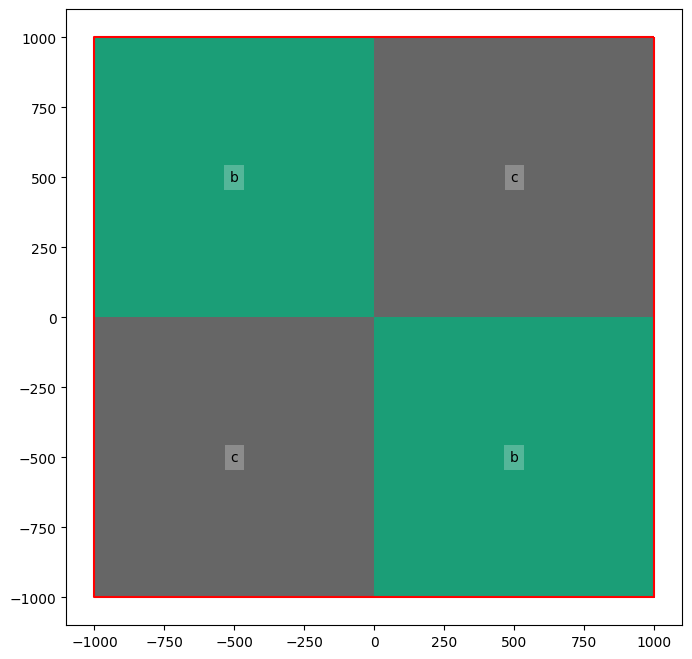

In [6]:
weave_unit.plot(r = 0)

The important attributes of a unit of either type are its *tiles* `GeoDataFrame`, and its *prototile* `GeoDataFrame`. 

In [7]:
weave_unit.tiles, weave_unit.prototile

(  tile_id                                           geometry
 0       b  POLYGON ((-1000 1000, 0 1000, 0 0, -1000 0, -1...
 1       b  POLYGON ((1000 -1000, 0 -1000, 0 0, 1000 0, 10...
 2       c  POLYGON ((0 0, 0 -1000, -1000 -1000, -1000 0, ...
 3       c  POLYGON ((1000 1000, 1000 0, 0 0, 0 1000, 1000...,
                                             geometry
 0  POLYGON ((1000 1000, 1000 -1000, -1000 -1000, ...)

The *tiles* are the polygons that will carry different attributes from the data to be mapped. The *prototile* is the shape that will be copied and repeated across a region to produce the final map.  There is also a *regularised_prototile* which may help you visualize how the tiling will work. It is shown in red outline in the plot. A better example to show the distinctions among these unit attributes is the example below.

<Axes: >

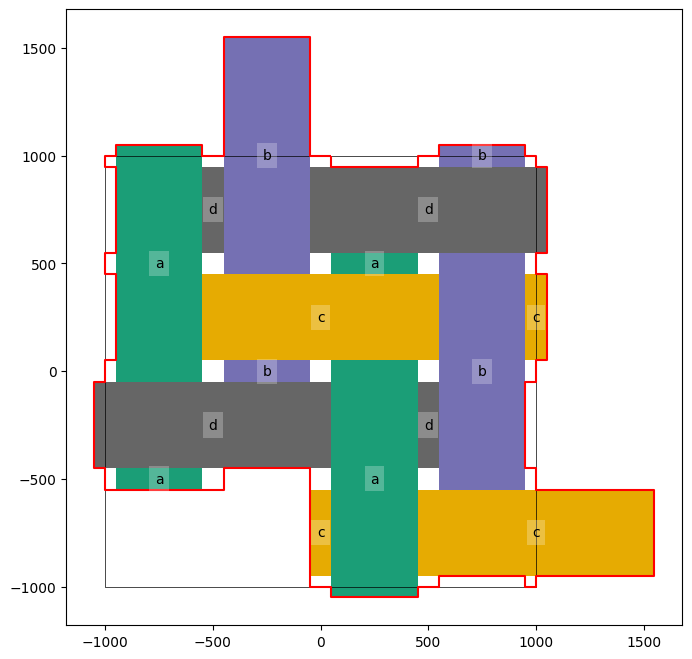

In [8]:
weave_unit = WeaveUnit(weave_type = "twill", spacing = 500, aspect = 0.8, 
                       n = 2, strands = "ab|cd", crs = data.crs)
weave_unit.plot()

Here you can see how a more complex unit will 'jigsawed' together (the red outlinedshape), when it is tiled using the base prototile shape (the fine black square). This example also shows some of the options in the `WeaveUnit` case:

+ `spacing` is the spacing of strands in the weave in units of the CRS. Defaults to 1000 (so it will not make sense if coordinates are in latitude-longitude).
+ `aspect` is the proportion of the spacing taken up by the strands. A 500m spacing with aspect 0.8 has 400m wide strands with a gap of 100m between them. Defaults to 1.0.
+ `strands` is a specification for how strands going in the different directions are assigned to colour groups in the final map. the `'|'` separator splits the specification into sequences that apply in each weave axis. In the example there are to be two groups in one direction `'ab'` and two in the other `'cd'`. Defaults to `"a|b"` 
+ `weave_type` specifies a number of possible weave patterns, among them `"plain"`, `"twill"` and `"basket"`. The next cell shows three of these applied to the same general characteristics. Defaults to `"plain"`.
+ `crs` is the CRS of the map that will be made. This has to be specified so we can use various geospatial operations in building the unit. It will be set to 3857 (web Mercator) if not specified. It should usually be set to the CRS of the data to be mapped.

<Axes: >

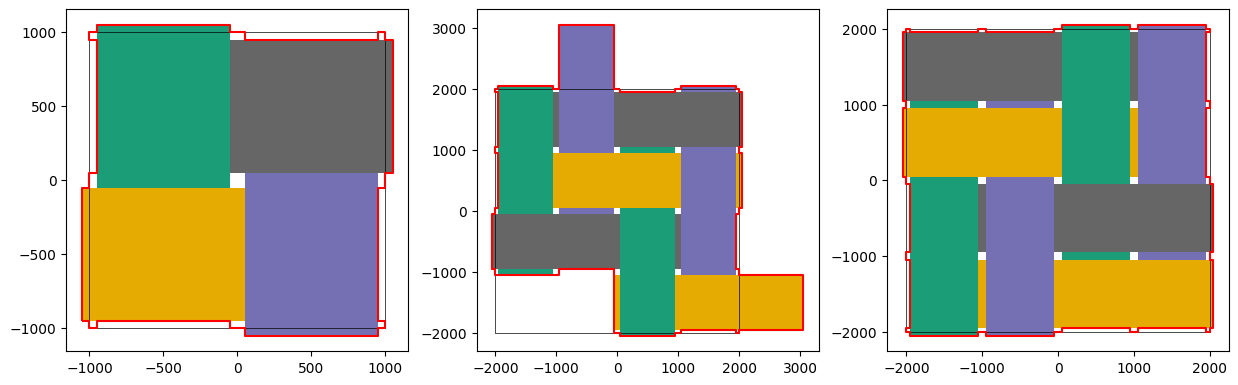

In [9]:
w1 = WeaveUnit(weave_type = "plain", aspect = 0.9, strands = "ab|cd",
               crs = data.crs)
w2 = WeaveUnit(weave_type = "twill", aspect = 0.9, strands = "ab|cd",
               crs = data.crs)
w3 = WeaveUnit(weave_type = "basket", aspect = 0.9, strands = "ab|cd",
               crs = data.crs)

fig = pyplot.figure(figsize = (15, 5))
ax = fig.add_subplot(131)
w1.plot(ax = ax, show_ids = False)
ax = fig.add_subplot(132)
w2.plot(ax = ax, show_ids = False)
ax = fig.add_subplot(133)
w3.plot(ax = ax, show_ids = False)

It is generally easier to see what the weave pattern itself looks like using a simple strand specification.

<Axes: >

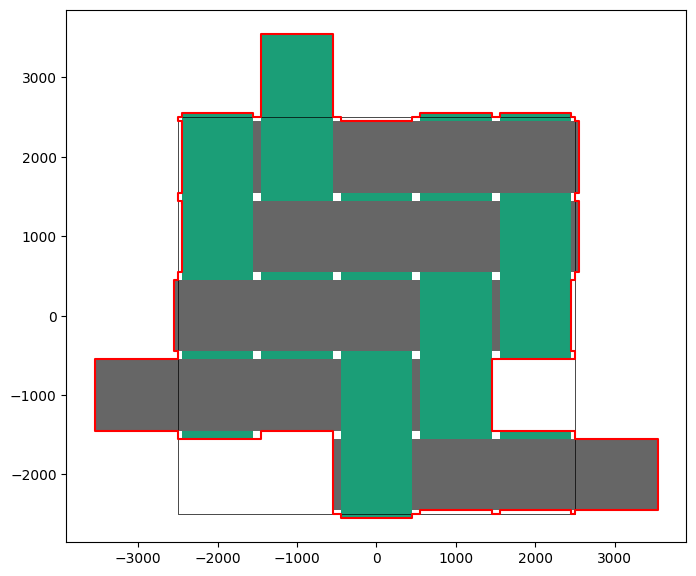

In [10]:
w = WeaveUnit(
    weave_type = "twill", n = (2, 3), 
    strands = "a|b", aspect = 0.9)
w.plot(show_ids = False)

### Seriously... pick a tile!
Many different tiles are available. 

In addition to the variety that can be generated as `WeaveUnit`s there are many possibilities for `TileUnit`s. See the notebook [*All the tiles!*](all-the-tiles.ipynb) for most of the options.

The most important minimal consideration is that the tile unit you choose has enough distinct elements to symbolise the attributes you want to map. With a weave you can pick essentially any number of distinct elements. With the conventional tile units you get the number of distinct elements that the tiling offers.

You could also make your own, since the *elements* and *tile* attributes are `geopandas.GeoDataFrame` objects they could be read in from a geospatial dataset. But that is probably a topic for another notebook.

## 2. Make a tiling
We will work with the object `weave_unit` we made a few cells up the page.

To tile the dataset with this, we make a `Tiling` object like this

In [11]:
from weavingspace import Tiling

tiling = Tiling(weave_unit, data)

Like `Tileable`s this is mostly a collection of `GeoDataFrame`s. The key one is `TilingUnit.tiles` which it's easiest to take a look at with a map:

<Axes: >

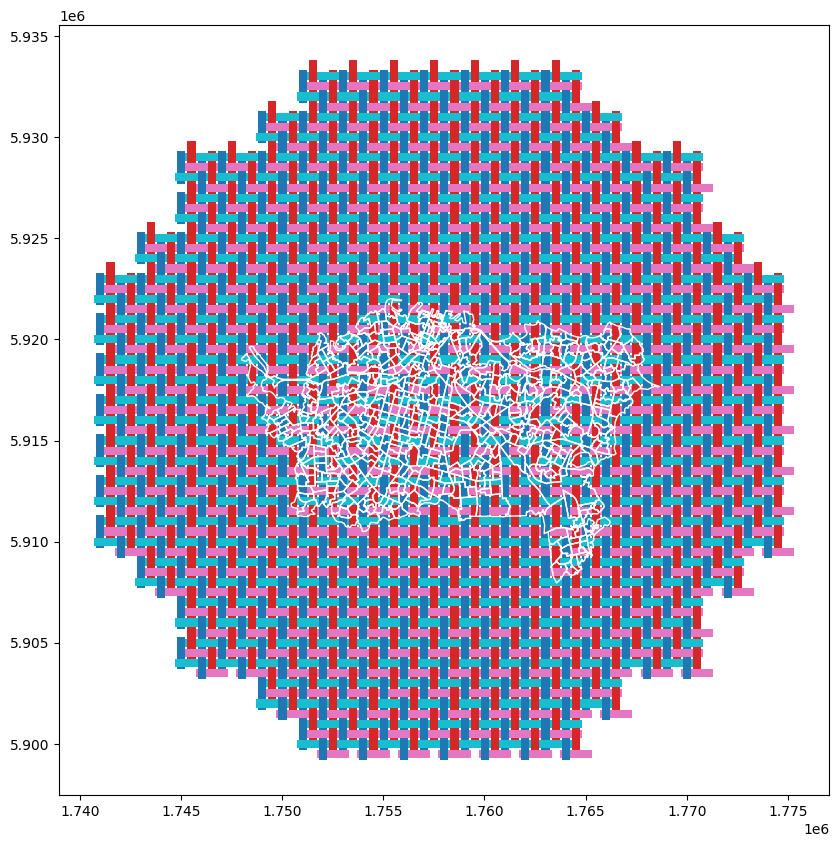

In [12]:
ax = tiling.tiles.plot(column = "tile_id", figsize = (10, 10))
data.plot(ax = ax, ec = "w", fc = "#00000000")

The `Tiling` class tiles a circular region larger than the map area so that we can request a map at any rotation and get a result back quickly. That's the next step.

## 3. Make a tiled map
This is a little more complex, because you have to specify the mapping from tile element IDs to dataset variables, and from dataset variable to your preferred colour scheme. A draft mode option lets you check the appearance of the tiling without worrying about symbolisation of variables.

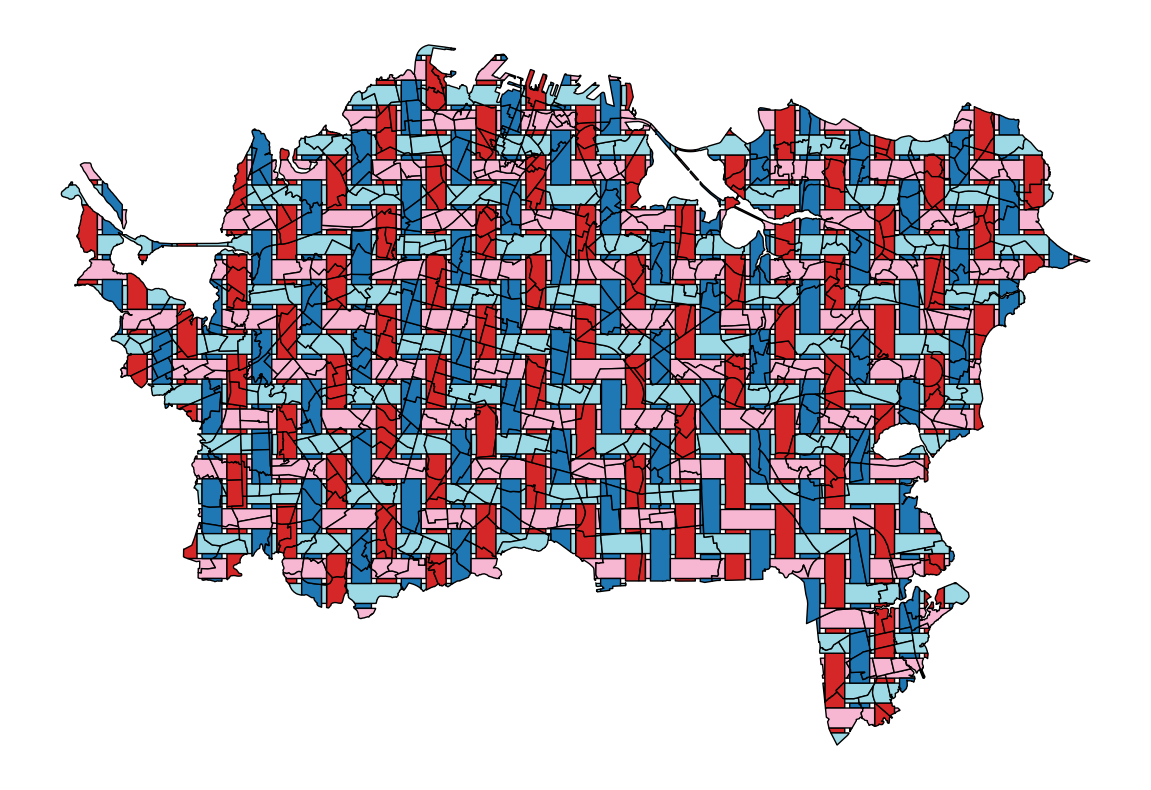

In [13]:
tiled_map = tiling.get_tiled_map(prioritise_tiles = False)
fig = tiled_map.render(draft_mode = True, figsize = (20, 10), edgecolor = "k")

In this example we are breaking tiles at the boundaries in the original data (I specified `edgecolor = "k"` so you can see them). We can have tiling elements over-ride the original boundaries, by setting `prioritise_tiles = True`&mdash;this is actually the default setting, so you don't need to set it, and it seems more in keeping with the aesthetic of the approach to have tiles override zone boundaries:

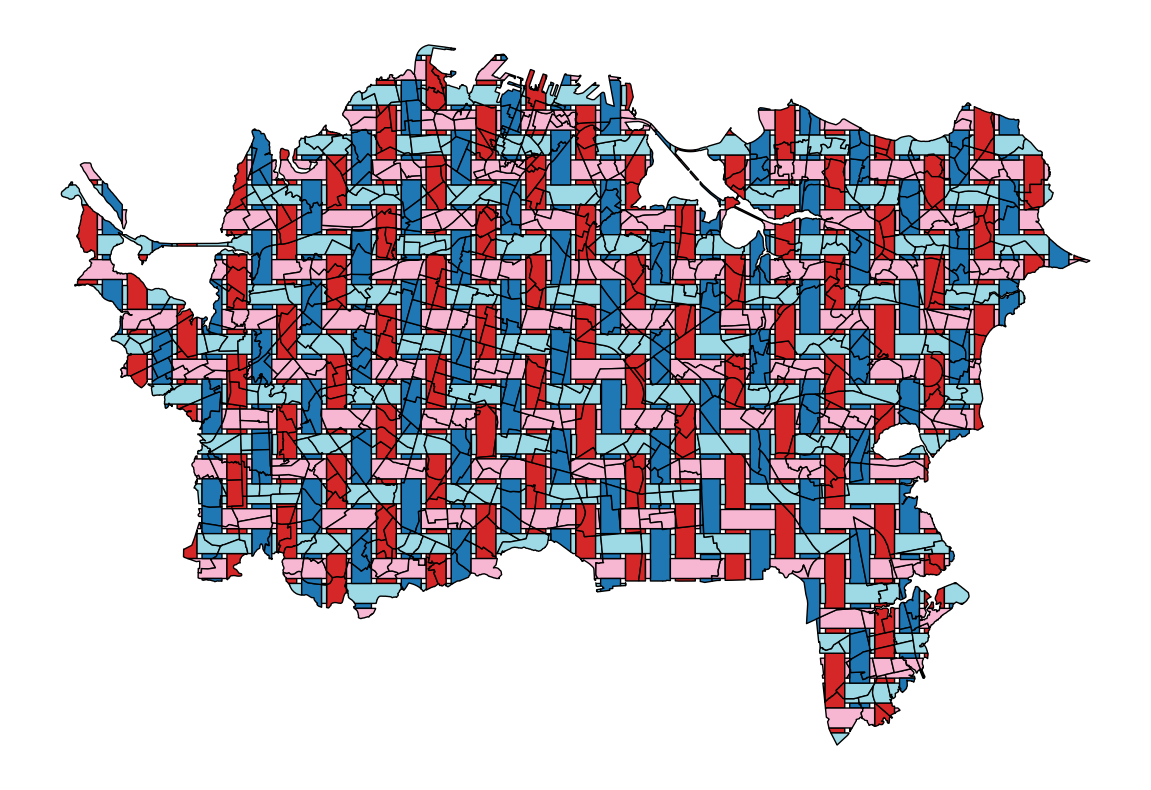

In [14]:
fig = tiled_map.render(draft_mode = True, ec = "k")

Wait, wut?! The tiling has ragged edges by default, again in keeping with the aesthetic... this is a tiled map, not a map with tiles on. If you would prefer to see the boundaries of your region respected, then set `ragged_edges = False`:

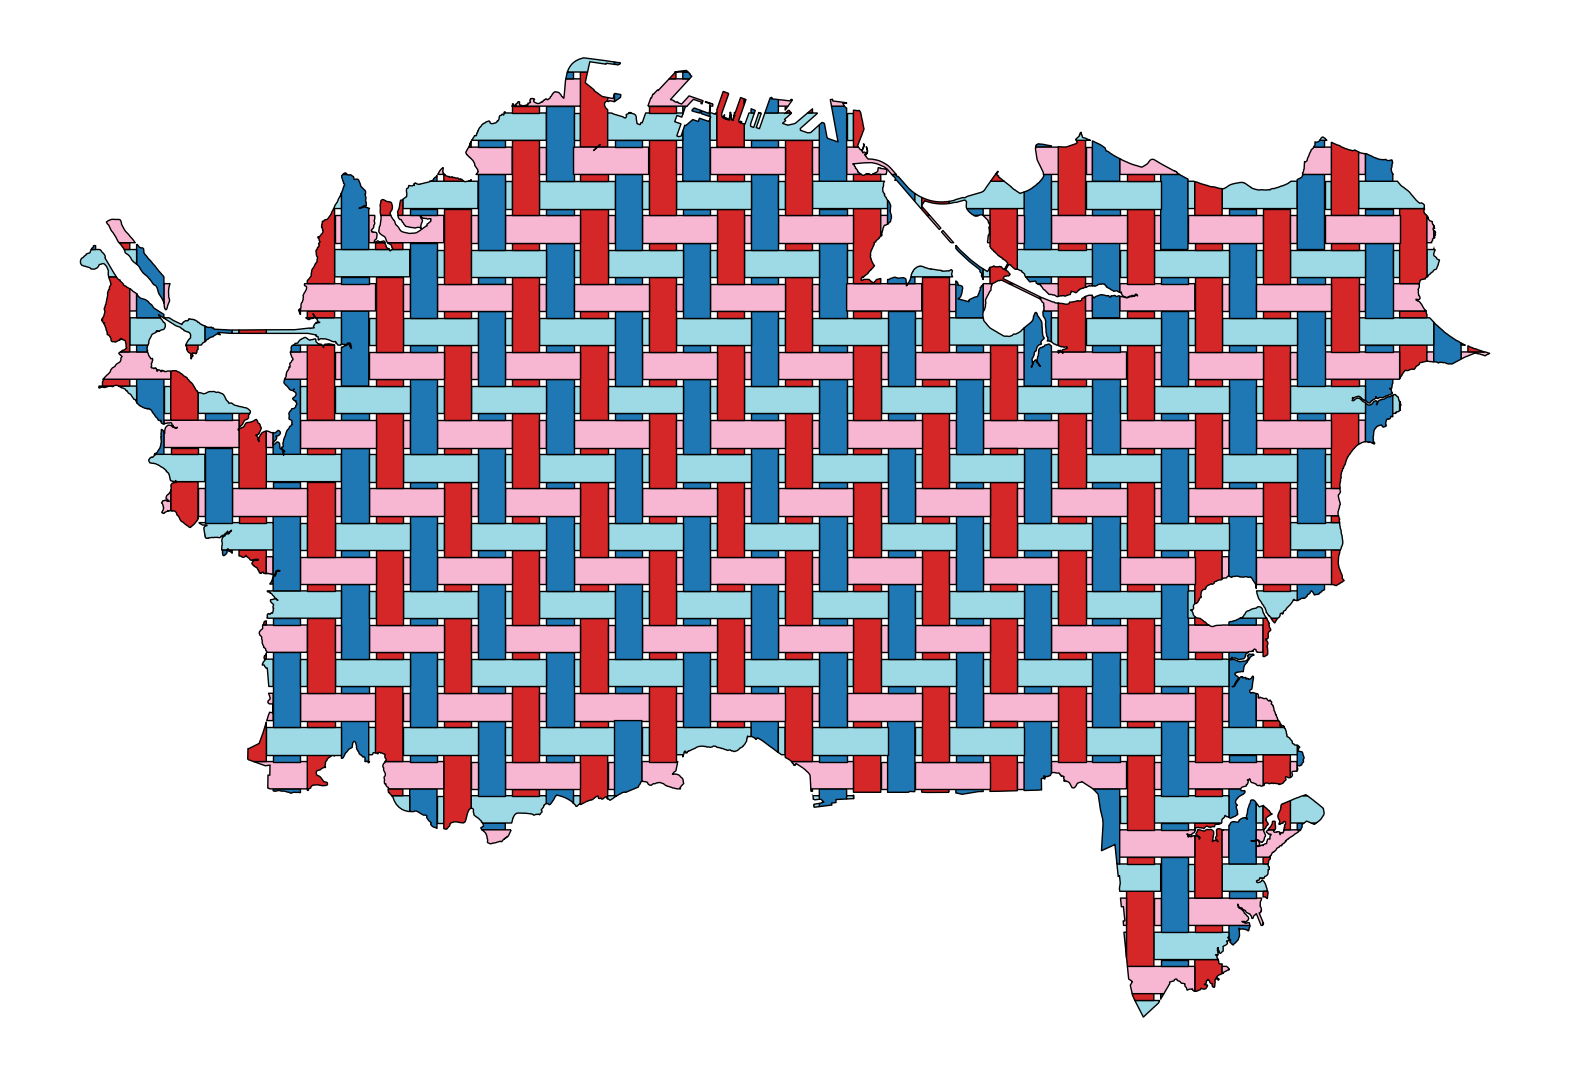

In [15]:
tiled_map = tiling.get_tiled_map(ragged_edges = False)
fig = tiled_map.render(draft_mode = True, ec = "k")

These aren't really the kind of maps we are after (even if they are pretty). Instead we want to associate with each `tile_id` in the tiling a different attribute from the dataset. You can do this either by saving the `tiled_map` to a GPKG (using `tiled_map.to_file()`) and doing map preparation in a tool of your choice (QGIS, ArcGIS, R, or whatever), or we provide basic mapping in the module. 

You have to supply at a minimum a list of the variables you wish to map (`vars_to_map`) and the colourmaps you want to apply (`colors_to_use`). The colourmaps are named per the information on [this page in the `matplotlib` documentation](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

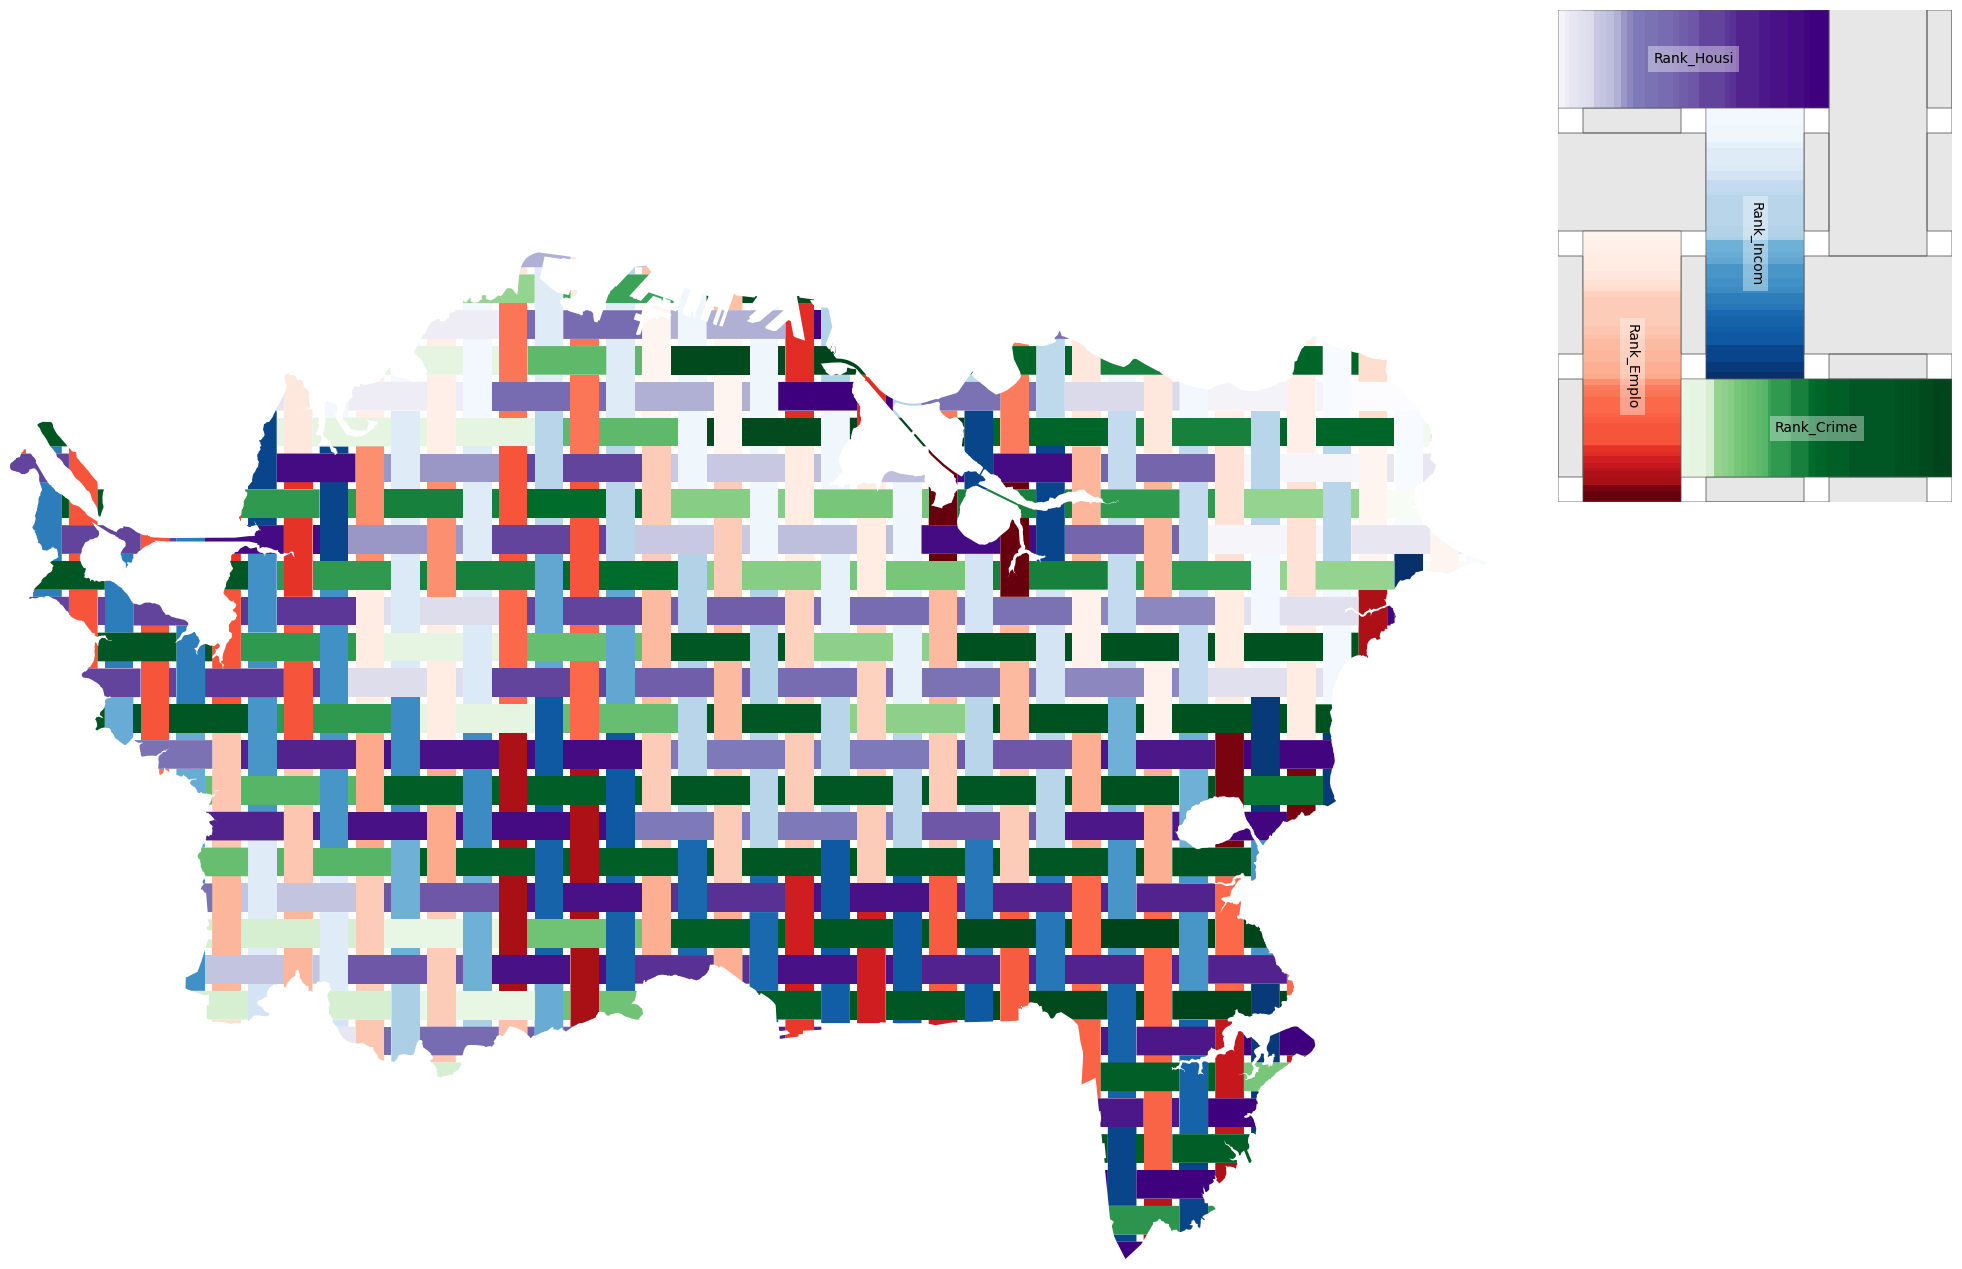

In [16]:
tile_ids = weave_unit.tiles.tile_id.unique()

vars = ['Rank_Emplo', 'Rank_Incom', 'Rank_Crime', 'Rank_Housi']
cmaps = ["Reds", "Blues", "Greens", "Purples"]

tiled_map.ids_to_map = list("abcd")
tiled_map.vars_to_map = vars
tiled_map.colors_to_use = cmaps
tiled_map.n_classes = 0
tiled_map.draft_mode = False
fig = tiled_map.render()

You can see right away that this is a poor example with the tiling elements much too large for the map. Nevertheless, we recommend starting coarse like this until you know what it is you want. 

Here's a better example all in one cell. Note that in a notebook setting we assign the result of the `render()` method to a variable to avoid two maps being displayed.

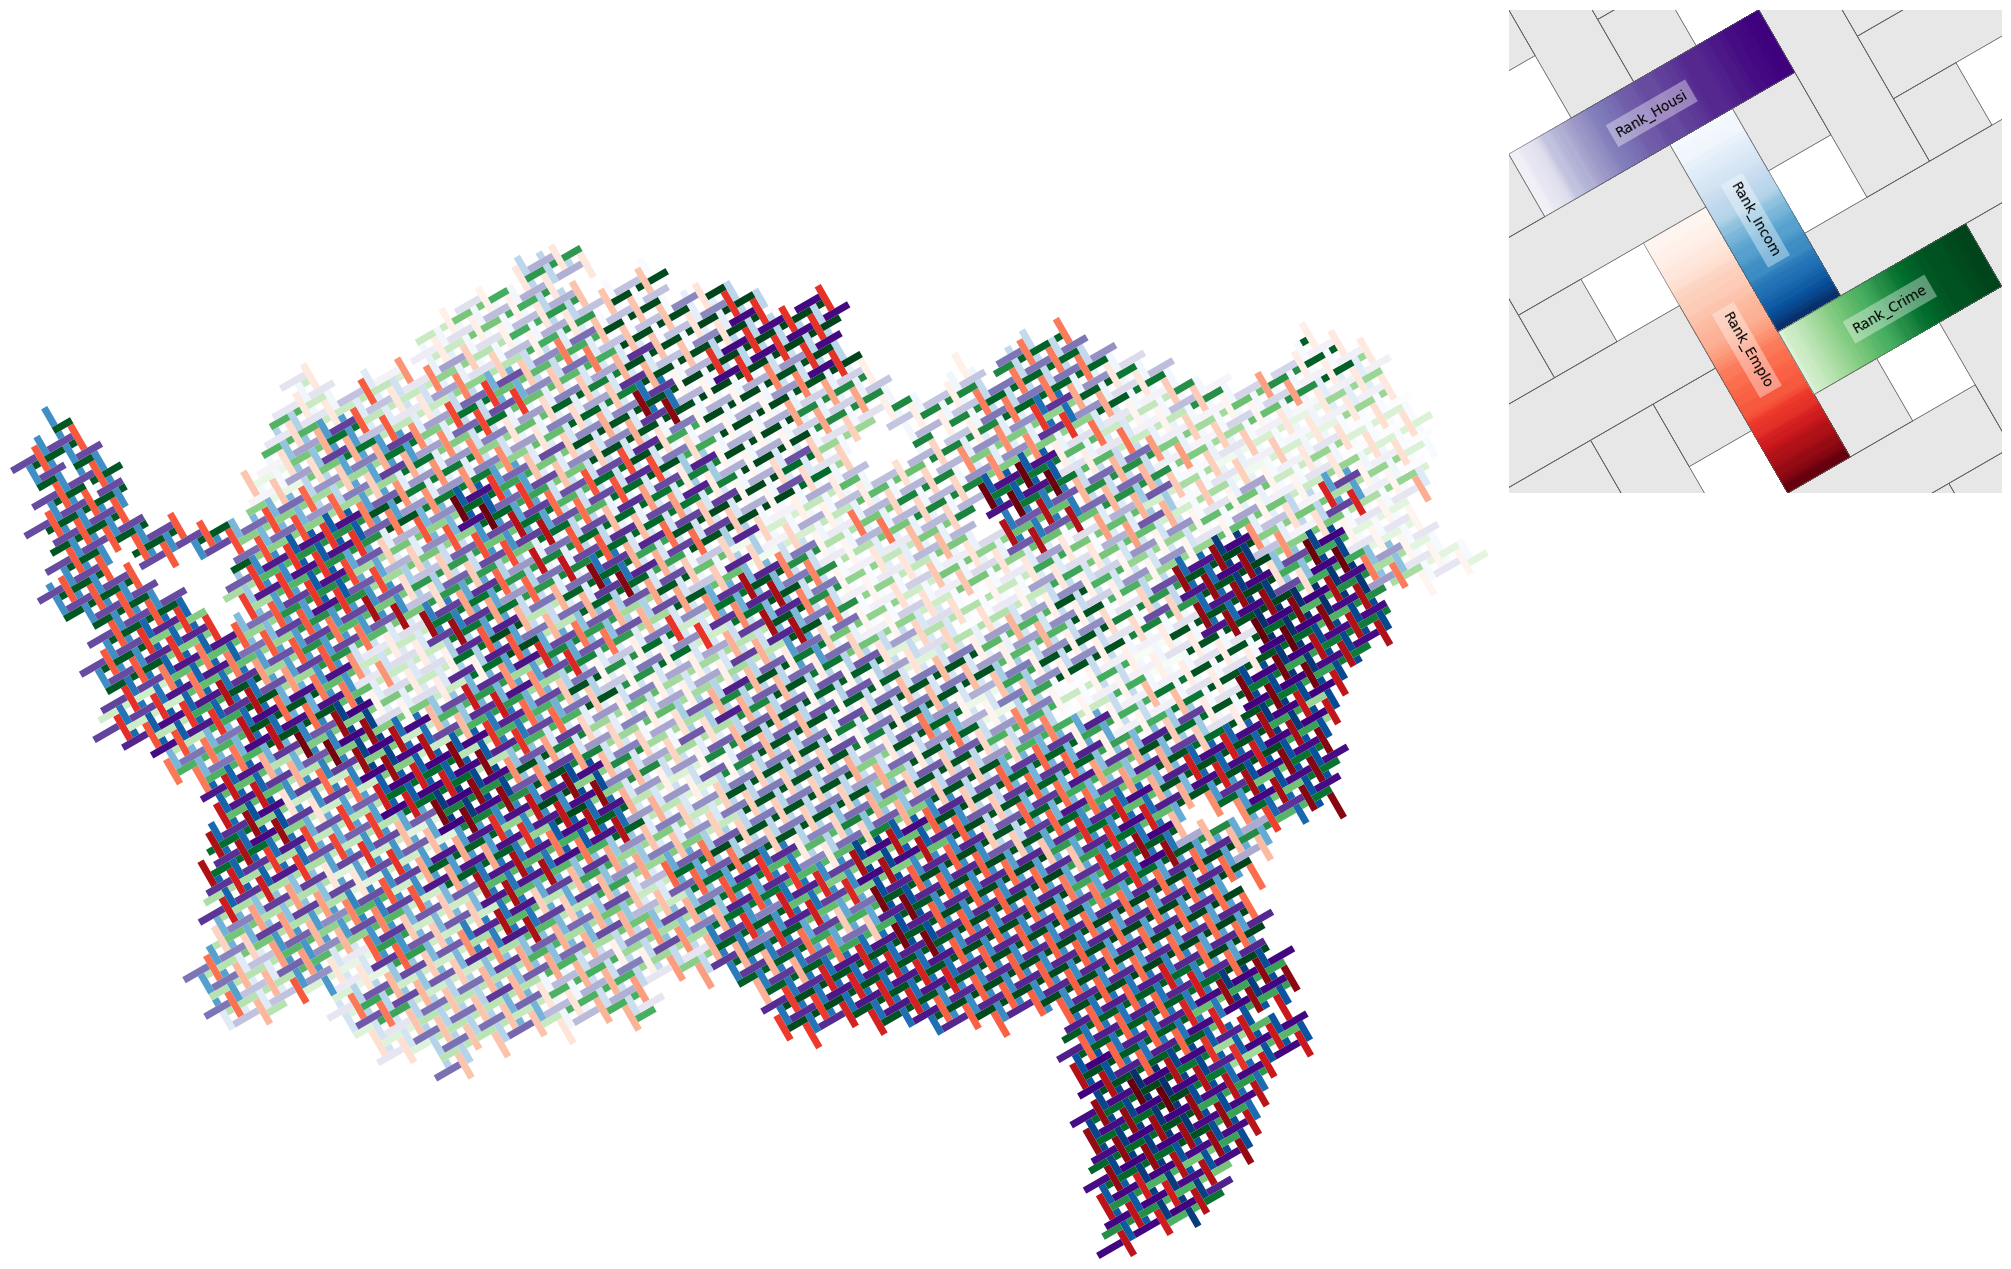

In [17]:
weave_unit = WeaveUnit(spacing = 100, weave_type = "twill", n = 3,
                       strands = "ab-|cd-", crs = data.crs).transform_rotate(30)

tiling = Tiling(weave_unit, data)
tiled_map = tiling.get_tiled_map()
fig = tiled_map.render(ids_to_map = list("abcd"), vars_to_map = vars, colors_to_use = cmaps)

Notice how with a finer grained tiling the ragged edges actually look pretty cool (or at least we think they do...).

And here is a more 'conventional' tiling example. We can reuse the `vars_to_map` and `colors_to_use` lists since the data hasn't changed, we just make a new unit, a `TileUnit` this time, and a new `Tiling` and generate a new tiled map from it.

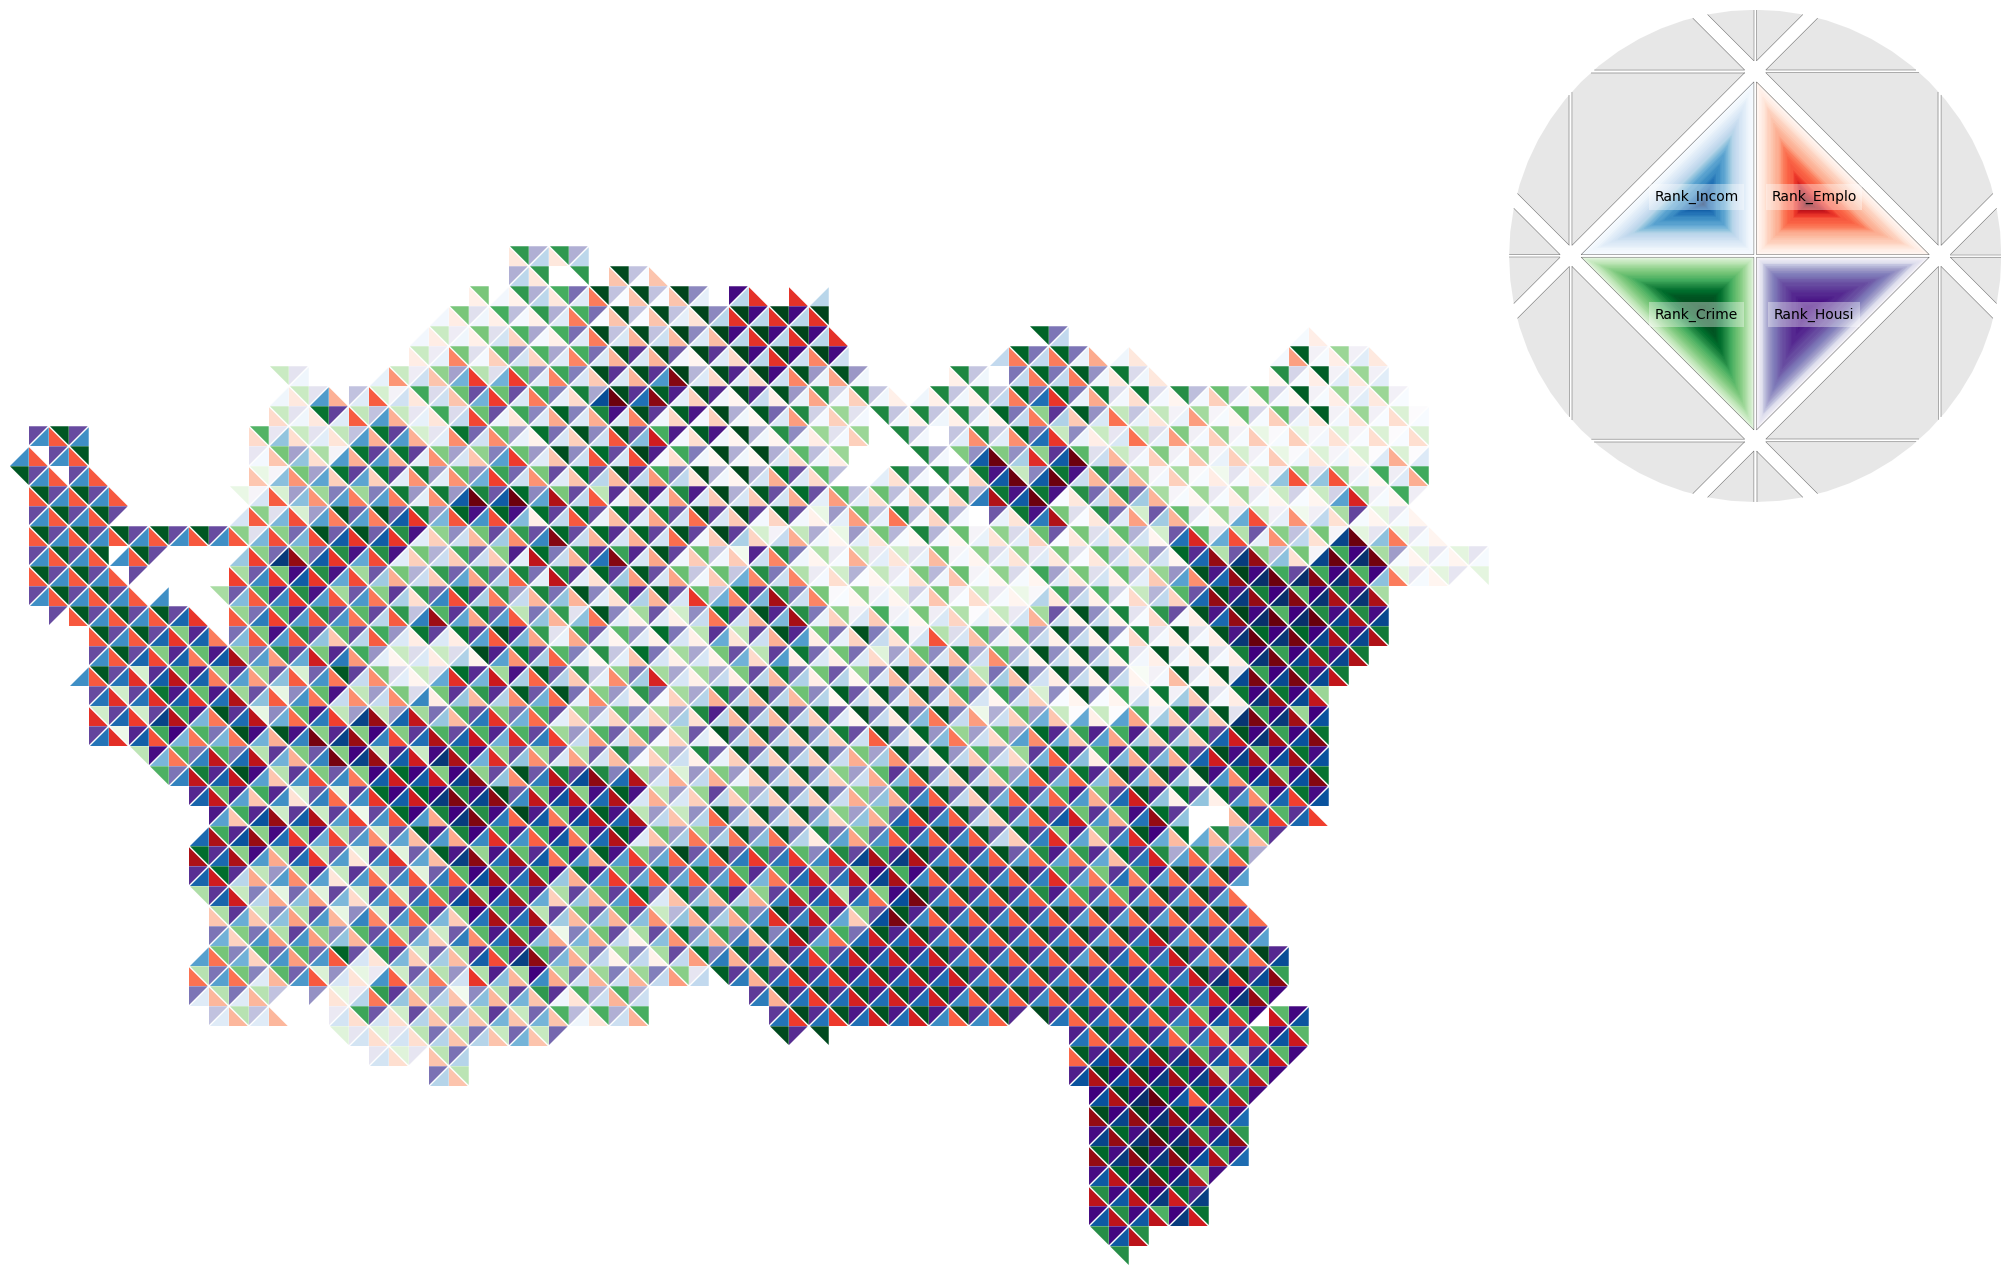

In [18]:
tile_unit = TileUnit(spacing = 400, tiling_type = "laves", code = "4.8.8", 
                     crs = data.crs).transform_rotate(45).inset_prototile(8).inset_tiles(2)
tiling = Tiling(tile_unit, data)
tiled_map = tiling.get_tiled_map()

fig = tiled_map.render(ids_to_map = list("abcd"), vars_to_map = vars, colors_to_use = cmaps, use_ellipse = True)

You might find it easier to make a map in a different tool, in which case export the tiled map produced by `Tiling.get_tiled_map()` to a geospatial data format, with `tiled_map.to_file("some_file.gpkg")`.

If you find the legends useful, you can export these to SVG or other graphical format with:

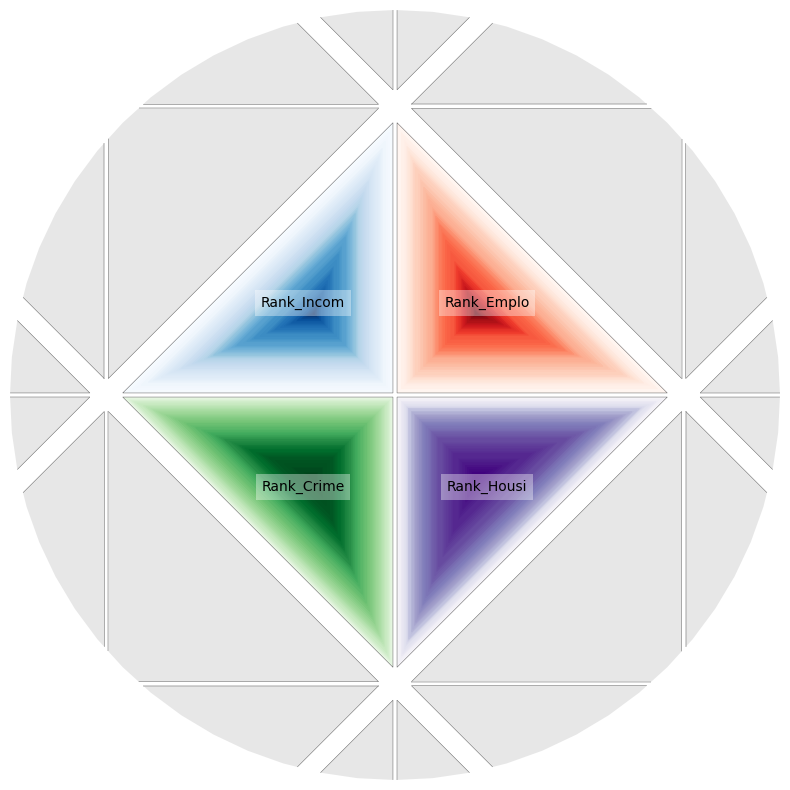

In [19]:
fig = pyplot.figure(figsize = (10, 10))
ax = fig.add_subplot(111)

tiled_map.plot_legend(ax)
# and then
# fig.savefig("legend.svg")